<h1>Encodings for Next Step Activity Prediction</h1>
<br/>
<h5>Lorenzo Manuel Cirac Monteagudo</h5>
<h5>Supervisor: Ana Luisa Oliveira da Nobrega Costa</h5>
<h5>Chair: Information Systems</h5>
<h5>TUM School of Computation, Information and Technology</h5>
<br/>

<h3>Overview</h3>
<p>Next-step activity prediction is a supervised machine learning task where you predict what activity will happen next in a business process, given the history of activities that have already occurred in a case.</p>

<h3>Dataset Information</h3>
<p>Helpdesk dataset: <a href="https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets">https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets</a></p>
<p>This dataset contains events from a ticketing management process of the help desk of an Italian software company. The process consists of 9 activities, and all cases start with the insertion of a new ticket into the ticketing
management system. Each case ends when the issue is resolved and the ticket is closed.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

log = xes_importer.apply("data/helpdesk")
df = xes_converter.apply(log, variant=xes_converter.Variants.TO_DATA_FRAME)

parsing log, completed traces ::   0%|          | 0/4580 [00:00<?, ?it/s]

<h3>Dataset Exploration</h3>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21348 entries, 0 to 21347
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   concept:name          21348 non-null  object             
 1   lifecycle:transition  21348 non-null  object             
 2   org:resource          21348 non-null  object             
 3   time:timestamp        21348 non-null  datetime64[ns, UTC]
 4   Activity              21348 non-null  object             
 5   Resource              21348 non-null  object             
 6   case:concept:name     21348 non-null  object             
 7   case:variant          21348 non-null  object             
 8   case:variant-index    21348 non-null  int64              
 9   case:creator          21348 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(8)
memory usage: 1.6+ MB


In [4]:
df.head()

,concept:name,lifecycle:transition,org:resource,time:timestamp,Activity,Resource,case:concept:name,case:variant,case:variant-index,case:creator
0,Assign seriousness,complete,Value 2,2010-01-13 08:40:25+00:00,Assign seriousness,Value 2,Case3608,Variant 33,33,Fluxicon Disco
1,Take in charge ticket,complete,Value 2,2010-01-29 08:52:27+00:00,Take in charge ticket,Value 2,Case3608,Variant 33,33,Fluxicon Disco
2,Resolve ticket,complete,Value 2,2010-01-29 08:52:34+00:00,Resolve ticket,Value 2,Case3608,Variant 33,33,Fluxicon Disco
3,Closed,complete,Value 5,2010-02-13 08:52:48+00:00,Closed,Value 5,Case3608,Variant 33,33,Fluxicon Disco
4,Closed,complete,Value 5,2010-02-13 08:52:48+00:00,Closed,Value 5,Case3608,Variant 33,33,Fluxicon Disco


In [5]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import pm4py

print(f"Cases: {len(log)}")
print(f"Events: {sum(len(trace) for trace in log)}")
print(f"Activities: {len(pm4py.get_event_attribute_values(log, "concept:name"))}")
print(f"Variants: {len(pm4py.stats.get_variants(log))}")

activities = pm4py.get_event_attribute_values(log, "concept:name")
print("\nMost common activities:")
for activity, count in sorted(activities.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"* {activity}: {count}")

Cases: 4580
Events: 21348
Activities: 14
Variants: 226

Most common activities:
* Take in charge ticket: 5060
* Resolve ticket: 4983
* Assign seriousness: 4938
* Closed: 4574
* Wait: 1463


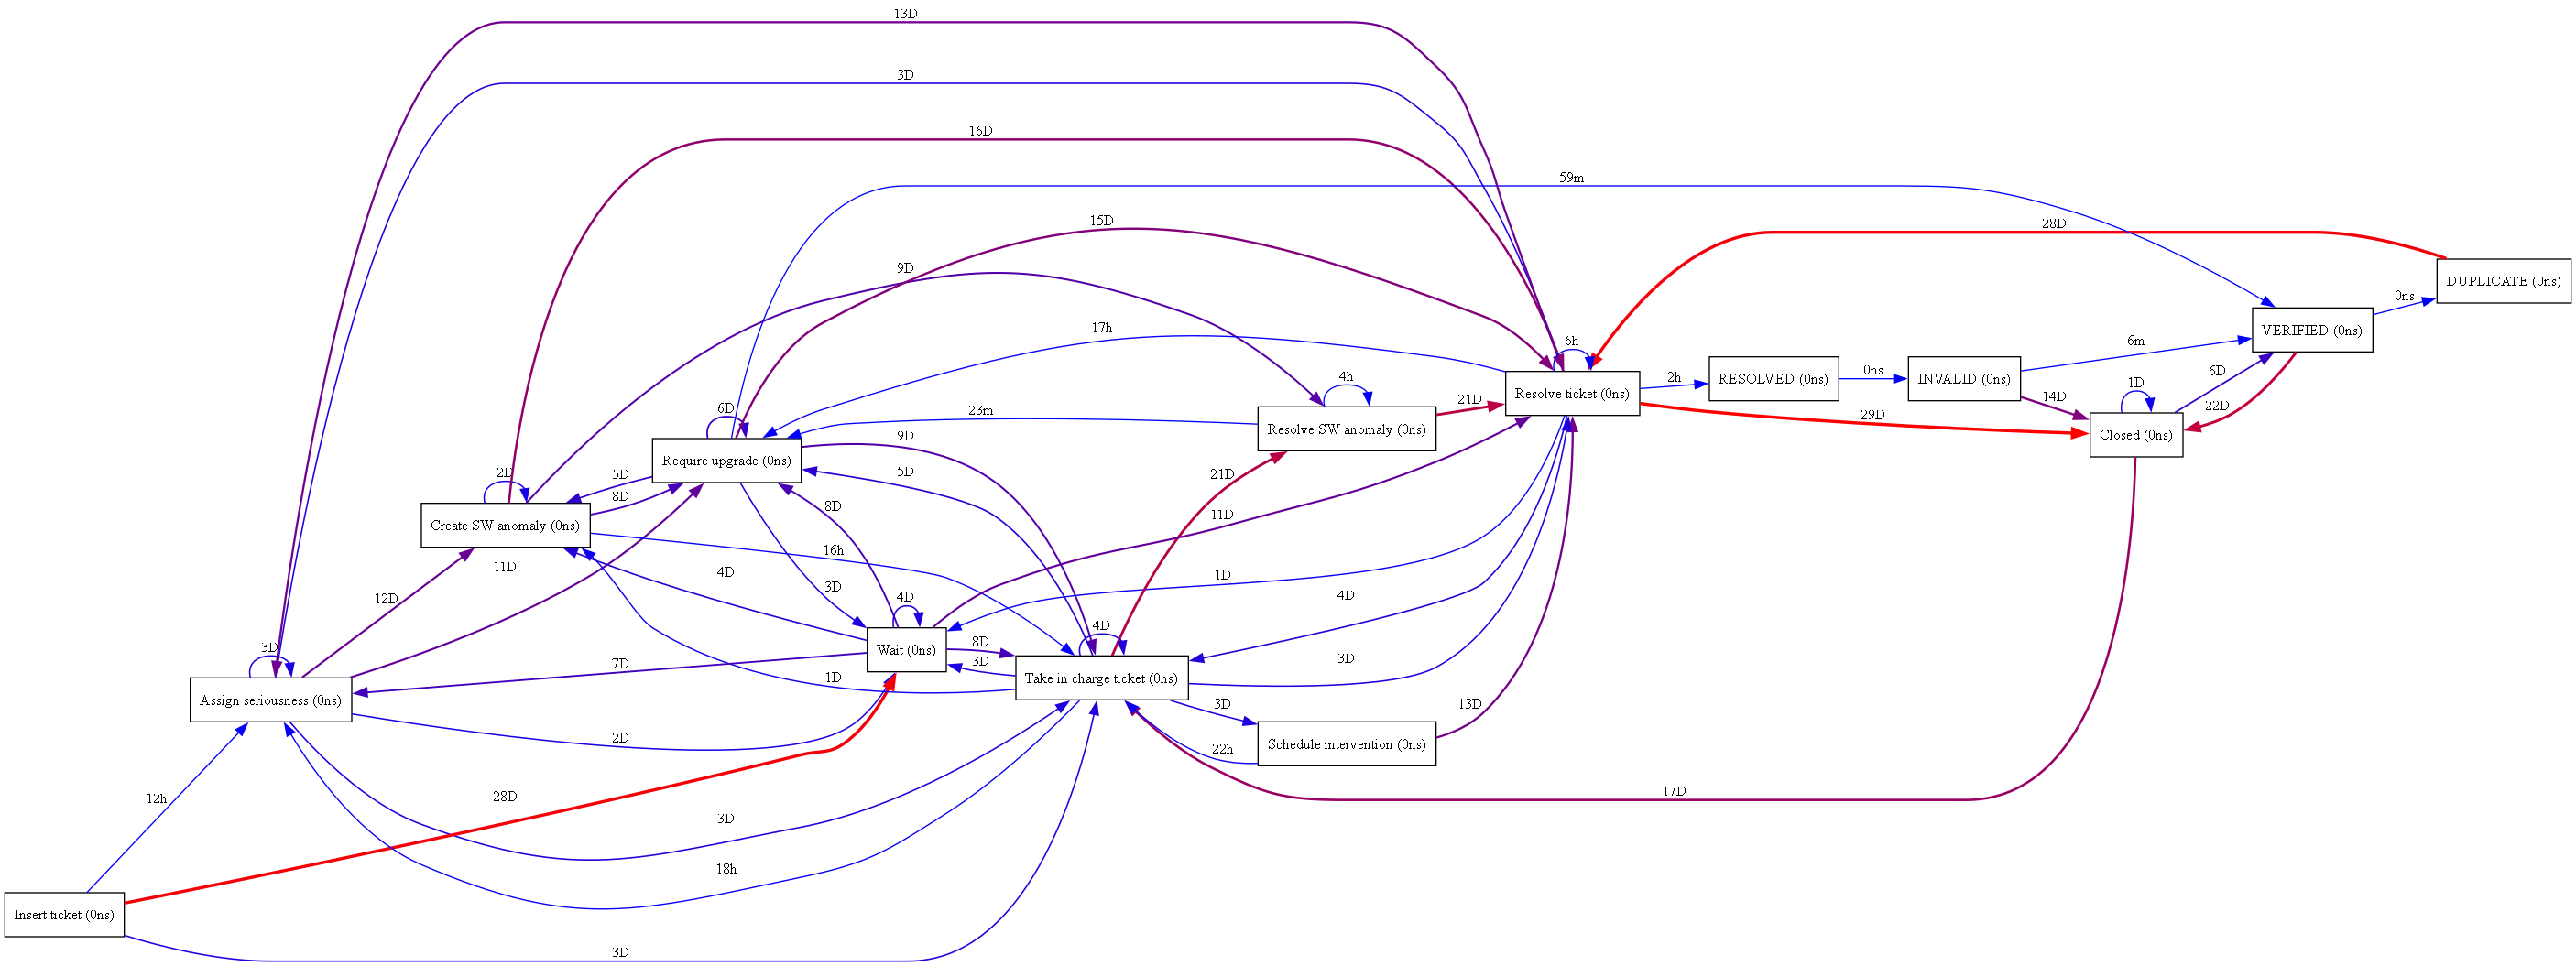

In [6]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin"

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_vis
from IPython.display import Image, display

dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_vis.apply(dfg, log=log, variant=dfg_vis.Variants.PERFORMANCE)

output_path = "output/performance_dfg_helpdesk.png"
dfg_vis.save(gviz, output_path)
display(Image(filename=output_path))

<h3>Data Cleaning & Prefix Generation</h3>

In [7]:
# Clean Data
df = df.rename(columns = {
    "case:concept:name": "case_id",
    "concept:name": "activity",
    "org:resource": "resource",
    "time:timestamp": "timestamp"
})

df = df[["case_id", "activity", "resource", "timestamp"]]
df["next_activity"] = df.groupby("case_id")["activity"].shift(-1)
df = df[df["next_activity"].notna()]
df = df.sort_values(by = ["case_id", "timestamp"])

df.head(10)

,case_id,activity,resource,timestamp,next_activity
17612,Case1,Assign seriousness,Value 1,2012-10-09 14:50:17+00:00,Take in charge ticket
17613,Case1,Take in charge ticket,Value 1,2012-10-09 14:51:01+00:00,Take in charge ticket
17614,Case1,Take in charge ticket,Value 2,2012-10-12 15:02:56+00:00,Resolve ticket
17615,Case1,Resolve ticket,Value 1,2012-10-25 11:54:26+00:00,Closed
212,Case10,Assign seriousness,Value 2,2010-02-10 08:50:20+00:00,Take in charge ticket
213,Case10,Take in charge ticket,Value 2,2010-03-19 08:47:06+00:00,Resolve ticket
214,Case10,Resolve ticket,Value 2,2010-03-19 08:47:13+00:00,Closed
19330,Case100,Assign seriousness,Value 1,2013-04-12 10:25:17+00:00,Take in charge ticket
19331,Case100,Take in charge ticket,Value 9,2013-04-24 10:24:01+00:00,Require upgrade
19332,Case100,Require upgrade,Value 9,2013-04-24 15:51:11+00:00,Resolve ticket


In [8]:
# Add Prefix
prefixes = []
for case_id, group in df.groupby("case_id"):
    activities = group["activity"].astype(str).tolist()
    resources = group["resource"].astype(str).tolist()
    timestamps = group["timestamp"].tolist()
    
    for i in range(1, len(activities)):   
        prefixes.append({
            "case_id": case_id,
            "step": i,
            "activities": activities[:i],
            "resources": resources[:i],
            "next_activity": activities[i],
        })

df = pd.DataFrame(prefixes)

df.head(10)

,case_id,step,activities,resources,next_activity
0,Case1,1,[Assign seriousness],[Value 1],Take in charge ticket
1,Case1,2,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 1]",Take in charge ticket
2,Case1,3,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2]",Resolve ticket
3,Case10,1,[Assign seriousness],[Value 2],Take in charge ticket
4,Case10,2,"[Assign seriousness, Take in charge ticket]","[Value 2, Value 2]",Resolve ticket
5,Case100,1,[Assign seriousness],[Value 1],Take in charge ticket
6,Case100,2,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 9]",Require upgrade
7,Case100,3,"[Assign seriousness, Take in charge ticket, Re...","[Value 1, Value 9, Value 9]",Resolve ticket
8,Case1000,1,[Assign seriousness],[Value 2],Assign seriousness
9,Case1000,2,"[Assign seriousness, Assign seriousness]","[Value 2, Value 2]",Take in charge ticket


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["case_id", "next_activity"])
y = df["next_activity"]

le = LabelEncoder()
y = le.fit_transform(df["next_activity"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025)

In [10]:
X

,step,activities,resources
0,1,[Assign seriousness],[Value 1]
1,2,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 1]"
2,3,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2]"
3,1,[Assign seriousness],[Value 2]
4,2,"[Assign seriousness, Take in charge ticket]","[Value 2, Value 2]"
...,...,...,...
12183,1,[Assign seriousness],[Value 9]
12184,2,"[Assign seriousness, Take in charge ticket]","[Value 9, Value 2]"
12185,3,"[Assign seriousness, Take in charge ticket, Wait]","[Value 9, Value 2, Value 9]"
12186,1,[Assign seriousness],[Value 1]


<h3>Encodings</h3>

<h5>One Hot Encoding</h5>
<ul>
    <li>Transforms categorical sequence data into numerical features</li>
    <li>Creates binary representation where each possible category gets its own feature column</li>
    <li>Uses MultiLabelBinarizer because each sample contains multiple activities/resources lists</li>
    <li>Preserves all information about which categories are present in each sequence</li>
    <li>Results in sparse feature matrix with many binary columns</li>
</ul>

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

def apply_one_hot_encoding(X_train, X_test):
    
    mlb_activities = MultiLabelBinarizer()
    mlb_resources = MultiLabelBinarizer()
    
    X_train_activities = mlb_activities.fit_transform(X_train["activities"])
    X_test_activities = mlb_activities.transform(X_test["activities"])
    
    X_train_resources = mlb_resources.fit_transform(X_train["resources"])
    X_test_resources = mlb_resources.transform(X_test["resources"])
    
    activities_columns = [f"activity_{cls}" for cls in mlb_activities.classes_]
    X_train_activities_df = pd.DataFrame(X_train_activities, columns=activities_columns, index=X_train.index)
    X_test_activities_df = pd.DataFrame(X_test_activities, columns=activities_columns, index=X_test.index)
    
    resources_columns = [f"resource_{cls}" for cls in mlb_resources.classes_]
    X_train_resources_df = pd.DataFrame(X_train_resources, columns=resources_columns, index=X_train.index)
    X_test_resources_df = pd.DataFrame(X_test_resources, columns=resources_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([X_train[["step"]], X_train_activities_df, X_train_resources_df], axis=1)
    X_test_encoded = pd.concat([X_test[["step"]], X_test_activities_df, X_test_resources_df], axis=1)
    return X_train_encoded, X_test_encoded, "one-hot encoding"

In [12]:
# apply_one_hot_encoding(X_train, X_test)[0].columns.tolist()

In [13]:
apply_one_hot_encoding(X_train, X_test)[0]

,step,activity_Assign seriousness,activity_Closed,activity_Create SW anomaly,activity_INVALID,activity_Insert ticket,activity_RESOLVED,activity_Require upgrade,activity_Resolve SW anomaly,activity_Resolve ticket,...,resource_Value 20,resource_Value 21,resource_Value 22,resource_Value 3,resource_Value 4,resource_Value 5,resource_Value 6,resource_Value 7,resource_Value 8,resource_Value 9
3281,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5864,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5482,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10781,3,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8020,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5331,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11102,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h5>Last State Encoding</h5>
<ul>
    <li>Focuses on the most recent actions in the sequence, capturing the final state before prediction</li>
    <li>Extracts the last n elements from activity and resource sequences (default n=3)</li>
    <li>Pads shorter sequences with "None" values to create fixed-length representation</li>
    <li>Creates positional features (last_activity_1, last_activity_2, etc.) that preserve order information</li>
    <li>Uses standard OneHotEncoder since each position now contains single categorical values instead of lists</li>
    <li>Assumes recent actions are more predictive of the next step than earlier actions in the sequence</li>
</ul>

In [14]:
from sklearn.preprocessing import OneHotEncoder

def apply_last_state_encoding(X_train, X_test, n=3):
    
    def extract_last_state(X):
        
        last_activities = X["activities"].apply(
            lambda x: (["None"] * max(0, n - len(x)) + x)[-n:]
        )
        last_resources = X["resources"].apply(
            lambda x: (["None"] * max(0, n - len(x)) + x)[-n:]
        )
        
        features = {"step": X["step"]}
        for i in range(n):
            features[f"last_activity_{i+1}"] = last_activities.apply(lambda x: x[i])
            features[f"last_resource_{i+1}"] = last_resources.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=X.index)
    
    X_train_new = extract_last_state(X_train)
    X_test_new = extract_last_state(X_test)
    
    # one hot encode
    categorical_cols = [col for col in X_train_new.columns if col != "step"]
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_encoded_array = encoder.fit_transform(X_train_new[categorical_cols])
    X_test_encoded_array = encoder.transform(X_test_new[categorical_cols])
    
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    X_train_encoded_df = pd.DataFrame(X_train_encoded_array, columns=encoded_columns, index=X_train.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded_array, columns=encoded_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([X_train_new[["step"]], X_train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test_new[["step"]], X_test_encoded_df], axis=1)
    return X_train_encoded, X_test_encoded, "last_state_encoding"

In [15]:
# apply_last_state_encoding(X_train, X_test)[0].columns.tolist()

In [16]:
apply_last_state_encoding(X_train, X_test)[0]

,step,last_activity_1_Assign seriousness,last_activity_1_Create SW anomaly,last_activity_1_Insert ticket,last_activity_1_None,last_activity_1_Require upgrade,last_activity_1_Resolve SW anomaly,last_activity_1_Resolve ticket,last_activity_1_Schedule intervention,last_activity_1_Take in charge ticket,...,last_resource_3_Value 20,last_resource_3_Value 21,last_resource_3_Value 22,last_resource_3_Value 3,last_resource_3_Value 4,last_resource_3_Value 5,last_resource_3_Value 6,last_resource_3_Value 7,last_resource_3_Value 8,last_resource_3_Value 9
3281,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5864,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5482,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10781,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8020,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5331,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11102,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<h5>Index Encoding</h5>
<ul>
    <li>Focuses on the initial actions in the sequence, capturing early patterns and starting behaviors</li>
    <li>Extracts the first max_length elements from activity and resource sequences (default max_length=5)</li>
    <li>Pads shorter sequences with "None" values to create fixed-length representation</li>
    <li>Creates positional features (activity_1, activity_2, etc.) that preserve order information from the beginning</li>
    <li>Uses standard OneHotEncoder since each position now contains single categorical values instead of lists</li>
    <li>Assumes initial actions contain important patterns that influence the overall sequence trajectory</li>
</ul>

In [17]:
from sklearn.preprocessing import OneHotEncoder

def apply_index_encoding(X_train, X_test, max_length=5):

    if max_length is None:
        max_length = max(X_train["activities"].apply(len).max(), 
                        X_train["resources"].apply(len).max())
        
    def extract_index_features(X):
        
        activities = X["activities"].apply(
            lambda x: (x + ["None"] * max_length)[:max_length]
        )
        resources = X["resources"].apply(
            lambda x: (x + ["None"] * max_length)[:max_length]
        )
        
        features = {"step": X["step"]}
        for i in range(max_length):
            features[f"activity_{i+1}"] = activities.apply(lambda x: x[i])
            features[f"resource_{i+1}"] = resources.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=X.index)
    
    X_train_new = extract_index_features(X_train)
    X_test_new = extract_index_features(X_test)
    
    # one hot encode
    categorical_cols = [col for col in X_train_new.columns if col != "step"]
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_encoded_array = encoder.fit_transform(X_train_new[categorical_cols])
    X_test_encoded_array = encoder.transform(X_test_new[categorical_cols])
    
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    X_train_encoded_df = pd.DataFrame(X_train_encoded_array, columns=encoded_columns, index=X_train.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded_array, columns=encoded_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([X_train_new[["step"]], X_train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test_new[["step"]], X_test_encoded_df], axis=1)
    return X_train_encoded, X_test_encoded, "index_encoding"

In [18]:
# apply_index_encoding(X_train, X_test)[0].columns.tolist()

In [19]:
apply_index_encoding(X_train, X_test)[0]

,step,activity_1_Assign seriousness,activity_1_Create SW anomaly,activity_1_Insert ticket,activity_1_Resolve ticket,activity_1_Take in charge ticket,activity_1_Wait,resource_1_Value 1,resource_1_Value 10,resource_1_Value 11,...,resource_5_Value 2,resource_5_Value 20,resource_5_Value 22,resource_5_Value 3,resource_5_Value 4,resource_5_Value 5,resource_5_Value 6,resource_5_Value 7,resource_5_Value 8,resource_5_Value 9
3281,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5864,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5482,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10781,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8020,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5331,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11102,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h5>Inter Case Encoding</h5>
<ul>
    <li>Combines standard one-hot encoding with cross-case statistical information</li>
    <li>Uses MultiLabelBinarizer to create binary features for activities and resources like in one-hot encoding</li>
    <li>Adds step frequency feature (step_load) that captures how often each step appears across all training cases</li>
    <li>Provides global context about step popularity and rarity in the dataset</li>
    <li>Helps the model understand whether a step is common or unusual based on training data patterns</li>
    <li>Enriches individual sequence information with dataset-level statistics</li>
</ul>

In [20]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def apply_inter_case_encoding(X_train, X_test):
    
    step_counts = X_train["step"].value_counts().to_dict()
    
    resource_counts = {}
    for resources_list in X_train["resources"]:
        for resource in resources_list:
            resource_counts[resource] = resource_counts.get(resource, 0) + 1
    
    mlb_activities = MultiLabelBinarizer()
    mlb_resources = MultiLabelBinarizer()
    
    X_train_activities = mlb_activities.fit_transform(X_train["activities"])
    X_test_activities = mlb_activities.transform(X_test["activities"])
    
    X_train_resources = mlb_resources.fit_transform(X_train["resources"])
    X_test_resources = mlb_resources.transform(X_test["resources"])
    
    activities_columns = [f"activity_{cls}" for cls in mlb_activities.classes_]
    X_train_activities_df = pd.DataFrame(X_train_activities, columns=activities_columns, index=X_train.index)
    X_test_activities_df = pd.DataFrame(X_test_activities, columns=activities_columns, index=X_test.index)
    resources_columns = [f"resource_{cls}" for cls in mlb_resources.classes_]
    X_train_resources_df = pd.DataFrame(X_train_resources, columns=resources_columns, index=X_train.index)
    X_test_resources_df = pd.DataFrame(X_test_resources, columns=resources_columns, index=X_test.index)
    
    # add inter case features
    X_train_step_load = X_train["step"].map(step_counts)
    X_test_step_load = X_test["step"].map(step_counts).fillna(0)
    
    X_train_avg_resource_exp = X_train["resources"].apply(
        lambda x: sum(resource_counts.get(r, 0) for r in x) / len(x) if x else 0
    )
    X_test_avg_resource_exp = X_test["resources"].apply(
        lambda x: sum(resource_counts.get(r, 0) for r in x) / len(x) if x else 0
    )
    
    X_train_step_load_df = pd.DataFrame({"step_load": X_train_step_load, "avg_resource_experience": X_train_avg_resource_exp}, index=X_train.index)
    X_test_step_load_df = pd.DataFrame({"step_load": X_test_step_load, "avg_resource_experience": X_test_avg_resource_exp}, index=X_test.index)
    
    X_train_encoded = pd.concat([
        X_train[["step"]],
        X_train_step_load_df,
        X_train_activities_df, 
        X_train_resources_df
    ], axis=1)
    X_test_encoded = pd.concat([
        X_test[["step"]],
        X_test_step_load_df,
        X_test_activities_df, 
        X_test_resources_df
    ], axis=1)
    
    return X_train_encoded, X_test_encoded, "inter_case_encoding"

In [21]:
# apply_inter_case_encoding(X_train, X_test)[0].columns.tolist()

In [22]:
apply_inter_case_encoding(X_train, X_test)[0]

,step,step_load,avg_resource_experience,activity_Assign seriousness,activity_Closed,activity_Create SW anomaly,activity_INVALID,activity_Insert ticket,activity_RESOLVED,activity_Require upgrade,...,resource_Value 20,resource_Value 21,resource_Value 22,resource_Value 3,resource_Value 4,resource_Value 5,resource_Value 6,resource_Value 7,resource_Value 8,resource_Value 9
3281,1,3692,4130.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5864,1,3692,2277.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5482,3,1476,783.666667,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10781,3,1476,3224.333333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8020,2,3477,3063.500000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1,3692,456.000000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5331,3,1476,4324.666667,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,1,3692,4130.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11102,3,1476,2801.333333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h5>Aggregation Encoding</h5>
<ul>
    <li>Creates statistical summary features instead of binary encodings</li>
    <li>Computes sequence length (prefix_length) to capture how far the user has progressed</li>
    <li>Calculates diversity metrics (unique_activities, unique_resources) to measure behavioral variety</li>
    <li>Finds repetition patterns (most_frequent_activity/resource_count) to identify dominant behaviors</li>
    <li>Computes activity-to-resource ratio to understand interaction balance</li>
    <li>Results in a compact numerical feature set that summarizes sequence characteristics</li>
    <li>Reduces dimensionality compared to one-hot methods while preserving important statistical patterns</li>
</ul>

In [23]:
from collections import Counter

def apply_aggregation_encoding(X_train, X_test):
    
    def compute_aggregation_features(X):
        features = []
        for _, row in X.iterrows():
            activities = row["activities"]
            resources = row["resources"]
            
            features.append({
                "step": row["step"],
                "prefix_length": len(activities),
                "unique_activities": len(set(activities)),
                "unique_resources": len(set(resources)),
                "most_frequent_activity_count": max(Counter(activities).values()) if activities else 0,
                "most_frequent_resource_count": max(Counter(resources).values()) if resources else 0,
                "activity_resource_ratio": len(set(activities)) / len(set(resources)) if len(set(resources)) > 0 else 0
            })
        
        return pd.DataFrame(features, index=X.index)
    
    X_train_encoded = compute_aggregation_features(X_train)
    X_test_encoded = compute_aggregation_features(X_test)
    
    return X_train_encoded, X_test_encoded, "aggregation_encoding"

In [24]:
# apply_aggregation_encoding(X_train, X_test)[0].columns.tolist()

In [25]:
apply_aggregation_encoding(X_train, X_test)[0]

,step,prefix_length,unique_activities,unique_resources,most_frequent_activity_count,most_frequent_resource_count,activity_resource_ratio
3281,1,1,1,1,1,1,1.0
5864,1,1,1,1,1,1,1.0
5482,3,3,3,2,1,2,1.5
10781,3,3,3,2,1,2,1.5
8020,2,2,2,2,1,1,1.0
...,...,...,...,...,...,...,...
10124,1,1,1,1,1,1,1.0
5331,3,3,2,2,2,2,1.0
323,1,1,1,1,1,1,1.0
11102,3,3,3,3,1,1,1.0


<h5>Embeddings</h5>
<ul>
    <li>Treats activity and resource sequences as text documents by joining elements with spaces</li>
    <li>Uses TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to create weighted numerical features</li>
    <li>Considers both how often terms appear in individual sequences and how rare they are across the entire dataset</li>
    <li>Creates dense numerical features that capture the relative importance and discriminative power of different activities/resources</li>
    <li>Limited to top 50 features each for activities and resources to control dimensionality</li>
    <li>Results in continuous values rather than binary, where higher values indicate more important/distinctive terms</li>
</ul>

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_embedding_encoding(X_train, X_test):
    
    def lists_to_string(series):
        return series.apply(lambda x: " ".join(x))
    
    X_train_activities_str = lists_to_string(X_train["activities"])
    X_test_activities_str = lists_to_string(X_test["activities"])
    X_train_resources_str = lists_to_string(X_train["resources"])
    X_test_resources_str = lists_to_string(X_test["resources"])
    
    activity_vectorizer = TfidfVectorizer(max_features = 50)  
    resource_vectorizer = TfidfVectorizer(max_features = 50)
    
    X_train_activities_tfidf = activity_vectorizer.fit_transform(X_train_activities_str).toarray()
    X_test_activities_tfidf = activity_vectorizer.transform(X_test_activities_str).toarray()
    
    X_train_resources_tfidf = resource_vectorizer.fit_transform(X_train_resources_str).toarray()
    X_test_resources_tfidf = resource_vectorizer.transform(X_test_resources_str).toarray()
    
    activity_columns = [f"activity_{feat}" for feat in activity_vectorizer.get_feature_names_out()]
    resource_columns = [f"resource_{feat}" for feat in resource_vectorizer.get_feature_names_out()]
    
    X_train_activities_df = pd.DataFrame(X_train_activities_tfidf, columns=activity_columns, index=X_train.index)
    X_test_activities_df = pd.DataFrame(X_test_activities_tfidf, columns=activity_columns, index=X_test.index)
    X_train_resources_df = pd.DataFrame(X_train_resources_tfidf, columns=resource_columns, index=X_train.index)
    X_test_resources_df = pd.DataFrame(X_test_resources_tfidf, columns=resource_columns, index=X_test.index)
    X_train_encoded = pd.concat([
        X_train[["step"]],
        X_train_activities_df,
        X_train_resources_df
    ], axis=1)
    
    X_test_encoded = pd.concat([
        X_test[["step"]],
        X_test_activities_df,
        X_test_resources_df
    ], axis=1)
    
    return X_train_encoded, X_test_encoded, "embedding_encoding"

In [27]:
# apply_embedding_encoding(X_train, X_test)[0].columns.tolist()

In [28]:
apply_embedding_encoding(X_train, X_test)[0]

,step,activity_anomaly,activity_assign,activity_charge,activity_closed,activity_create,activity_in,activity_insert,activity_intervention,activity_invalid,...,resource_14,resource_15,resource_16,resource_17,resource_18,resource_19,resource_20,resource_21,resource_22,resource_value
3281,1,0.0,0.707107,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
5864,1,0.0,0.707107,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
5482,3,0.0,0.232590,0.357312,0.0,0.0,0.357312,0.000000,0.0,0.0,...,0.0,0.0,0.907005,0.0,0.0,0.0,0.0,0.0,0.0,0.287646
10781,3,0.0,0.177117,0.272093,0.0,0.0,0.272093,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.683050
8020,2,0.0,0.297502,0.457031,0.0,0.0,0.457031,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.529066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.944275,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.221264
5331,3,0.0,0.000000,0.461201,0.0,0.0,0.461201,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
323,1,0.0,0.707107,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
11102,3,0.0,0.232590,0.357312,0.0,0.0,0.357312,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.683050


<h3>Random Forest Model</h3>

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

results = []

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

encodings = [
    apply_one_hot_encoding, 
    apply_last_state_encoding,
    apply_index_encoding,
    apply_inter_case_encoding,
    apply_aggregation_encoding, 
    apply_embedding_encoding
]

for encoding in encodings:
    
    X_train_encoded, X_test_encoded, method = encoding(X_train, X_test)
    
    rf = RandomForestClassifier(random_state=2025)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
    grid_search.fit(X_train_encoded, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_encoded)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(method)
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()
    
    results.append({
        "encoding": method,
        "best_params": grid_search.best_params_,
        "model": best_model,
        "accuracy": accuracy,
        "f1_score": f1
    })

one-hot encoding
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7518
F1-Score: 0.7078

last_state_encoding
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.7654
F1-Score: 0.7238

index_encoding
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7564
F1-Score: 0.7117

inter_case_encoding
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7580
F1-Score: 0.7137

aggregation_encoding
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.7190
F1-Score: 0.6512

embedding_encoding
Best Params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7473
F1-Score: 0.7015



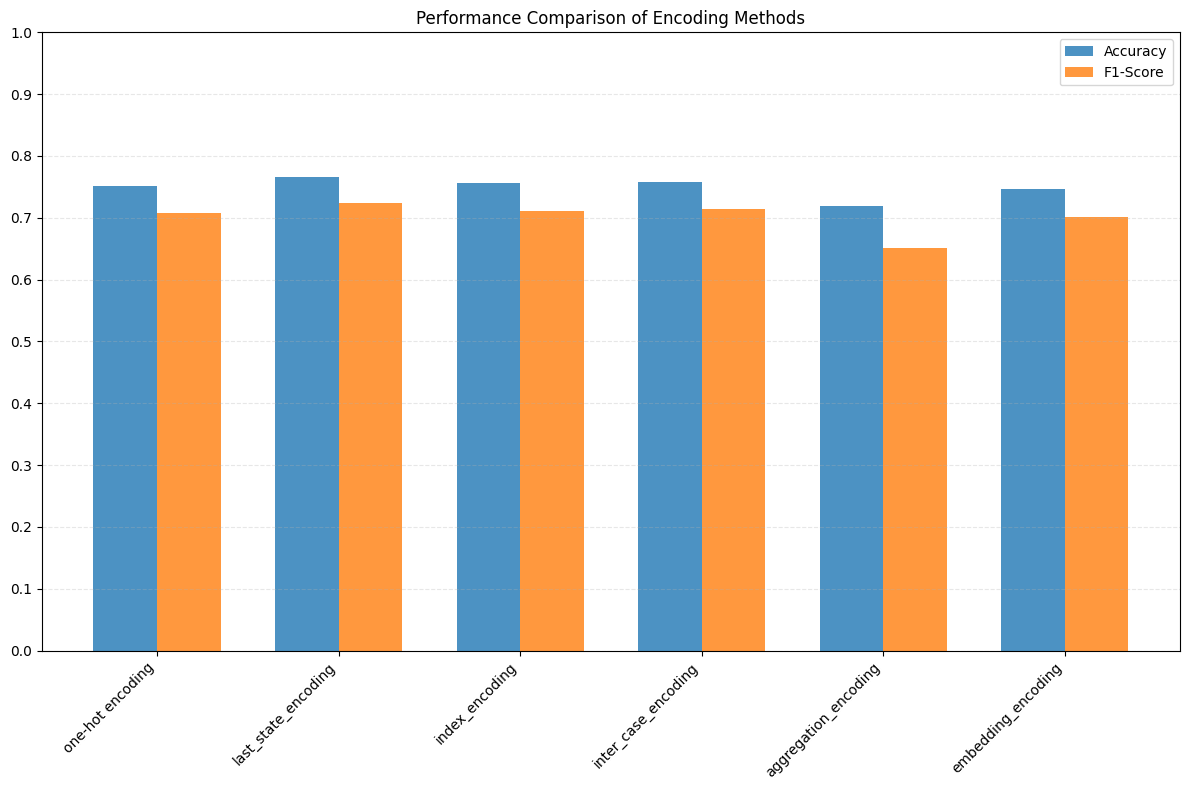

In [30]:
encodings = [result["encoding"] for result in results]
accuracies = [result["accuracy"] for result in results]
f1_scores = [result["f1_score"] for result in results]

x = np.arange(len(encodings))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, accuracies, width, label="Accuracy", alpha=0.8)
bars2 = ax.bar(x + width/2, f1_scores, width, label="F1-Score", alpha=0.8)

ax.set_title("Performance Comparison of Encoding Methods")
ax.set_xticks(x)
ax.set_xticklabels(encodings, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()